In [1]:
from sqlalchemy import create_engine
engine = create_engine('sqlite://', echo=False)

In [2]:
import graphviz
import numpy as np
import _ccpm

from sqlalchemy                 import create_engine, inspect, ForeignKey, Column, Integer, Float, String, and_, null
from sqlalchemy.orm             import relationship, remote, backref
from sqlalchemy.orm.collections import attribute_mapped_collection
from sqlalchemy.orm.session     import Session
from sqlalchemy.ext.declarative import declarative_base

Base = declarative_base()

#==============================================================================
class NetworkModel(Base):
    __tablename__ = 'models'

    id          = Column(Integer, primary_key = True, autoincrement=True)
    name        = Column(String, nullable=False)
    description = Column(String)
    
    #Work breakdown structure
    wbs        = relationship('WBSRecord', backref='model', cascade = 'all, delete-orphan')
    wbs_root   = relationship('WBSRecord', viewonly=True,
                              primaryjoin='and_(WBSRecord.model_id == NetworkModel.id, WBSRecord.parent_id == null())')
    
    # Network model elements
    activities = relationship('Activity' , backref='model', cascade = 'all, delete-orphan') # AoN AoA
    links      = relationship('Link'     , backref='model', cascade = 'all, delete-orphan') # AoN  -
    events     = relationship('Event'    , backref='model', cascade = 'all, delete-orphan') #  -  AoA
    
    #----------------------------------------------------------------------------------------------
    def __init__(self, name, description='', session=None):
        self.name        = name
        self.description = description
        
        if session:
            assert isinstance(session, Session)

            session.add(self)
            session.flush() #We've got an id now

    #----------------------------------------------------------------------------------------------
    def describe(self):
        print(self.id, ':', self.name, ':', self.description)
        
    #----------------------------------------------------------------------------------------------
    def refresh(self):
        sesion = inspect(self).session
        session.flush()
        session.refresh(self)
    
    #----------------------------------------------------------------------------------------------
    def copy(self, name=None):
        if not name:
            cp = NetworkModel(description=self.description, 
                              name='Copy of: ' + self.name,
                              session=inspect(self).session)
        else:
            cp = NetworkModel(description=self.description, 
                              name=name,
                              session=inspect(self).session)
        for w in self.wbs_root:
            w.copy(model=cp)
            
        #Copy dummy activities
        for a in self.activities:
            if not a.wbs:
                a.copy(model=cp)
        
        cp.links  = [l.copy(model=cp) for l in self.links]
        cp.events = [e.copy(model=cp) for e in self.events]

        cp.refresh()
        return cp
    
    #----------------------------------------------------------------------------------------------
    @property
    def _iwbs(self):
        return dict([(w.path, i) for i,w in enumerate(self.wbs)])
    
    def wbs_record(self, path):
        return self.wbs[self._iwbs[path]]

    #----------------------------------------------------------------------------------------------
    def delete_aoa(self):
        if not self.events:
            return
        self.events = []
        real_activities = []
        for a in self.activities:
            if a.wbs:
                a.src = None
                a.dst = None
                real_activities.append(a)
        #Don't need dummys!
        self.activities = real_activities
    
    #----------------------------------------------------------------------------------------------
    def _generate_aoa(self):
        act_id = session.query(Activity.id).filter(Activity.model_id == self.id).all()
        act_id = np.array(tuple(zip(*act_id))[0])
        
        lnk_ids = session.query(Link.src_id, Link.dst_id).filter(Link.model_id == self.id).all()
        lnk_ids = tuple(zip(*lnk_ids))

        lnk_src = np.array(lnk_ids[0])
        lnk_dst = np.array(lnk_ids[1])
        
        status, net_src, net_dst, lnk_src, lnk_dst = _ccpm.compute_aoa(act_id, lnk_src, lnk_dst)
        assert 0 == status

        #В net_src и net_dst у нас сначала идут реальные работы, а потом - фиктивные
        na = len(act_id)
        d  = np.max(act_id)
        for i in range(len(net_src)):
            if i < na:
                self.activities[i].src_id = int(net_src[i])
                self.activities[i].dst_id = int(net_dst[i])
            else:
                #Add a dummy
                d += 1
                dummy = Activity(model=self, id=int(d))
                dummy.src_id = int(net_src[i])
                dummy.dst_id = int(net_dst[i])
                
        for i in range(np.max(net_dst)):
            event = Event(self, int(i + 1))
    #----------------------------------------------------------------------------------------------
    def generate_aoa(self):
        self.delete_aoa()
        self._generate_aoa()
        self.refresh()

    #----------------------------------------------------------------------------------------------
    def _cpm_compute(self, target=None):
        if 'early' == target:
            act_base     = 'early_start'
            act_new      = 'early_finish'
            act_next     = 'dst'
            fwd          = 'out_activities'
            rev          = 'in_activities'
            delta        = lambda a : a.duration
            choise       = max
        elif 'layer' == target:
            act_base     = None
            act_new      = None
            act_next     = 'dst'
            fwd          = 'out_activities'
            rev          = 'in_activities'
            delta        = lambda a : 1
            choise       = max
        elif 'late' == target:
            act_base     = 'late_finish'
            act_new      = 'late_start'
            act_next     = 'src'
            fwd          = 'in_activities'
            rev          = 'out_activities'
            delta        = lambda a : - a.duration
            choise       = min
        else:
            raise ValueError("Unknown 'target' value!!!")
        
        if 'layer' != target:
            for a in self.activities:
                setattr(a, act_base, -1)
                setattr(a, act_new,  -1)
           
        n_dep = [len(getattr(e, rev)) for e in self.events]

        evt = [i for i,n in enumerate(n_dep) if 0 == n]
        assert 1 == len(evt)

        i = 0
        while True:

            e = self.events[evt[i]]
            base_val = getattr(e, target)

            for a in getattr(e, fwd):

                if act_base:
                    setattr(a, act_base, base_val)
                    
                new_val = base_val + delta(a)
                
                if act_new:
                    setattr(a, act_new, new_val)
                    
                next_evt = getattr(a, act_next)
                next_i   = self.events.index(next_evt)
                
                setattr(next_evt, target, choise(getattr(next_evt, target), new_val))

                n_dep[next_i] -= 1

                if 0 >= n_dep[next_i]:
                    evt.append(next_i)

            i += 1
            if i >= len(evt):
                break
    #----------------------------------------------------------------------------------------------
    def _do_cpm(self):
        assert 0 < len(self.events)
        
        self._cpm_compute('early')
        
        l = max([e.early for e in self.events])
        for e in self.events:
            e.late = l
        
        self._cpm_compute('late')
        
        for e in self.events:
            e.reserve = e.late - e.early
            
        for a in self.activities:
            a.reserve = a.late_start - a.early_start
    #----------------------------------------------------------------------------------------------
    def do_cpm(self):
        self._do_cpm()
        self.refresh()

    #----------------------------------------------------------------------------------------------
    def generate_viz(self):
        dot = graphviz.Digraph(node_attr={'shape': 'record', 'style':'rounded'})
        
        _mr = max([e.reserve for e in self.events])

        def _cl(res):
            if _mr <= 0:
                return '#ff0000'
            
            g = int(res / _mr * 255)
            r = 255 - g
            return '#' + hex(r)[2:] + hex(g)[2:] + '00'
        
        for e in self.events:
            dot.node(str(e.id), 
                     '{{%d |{%.1f|%.1f}| %.1f}}' % (e.id, 
                                                    e.early, 
                                                    e.late, 
                                                    e.reserve), 
                     color=_cl(e.reserve))
        
        _mr = max([a.reserve for a in self.activities])
        
        for a in self.activities:
            
            dot.edge(str(a.src_id), str(a.dst_id), 
                     label=(str(a.wbs_id) + '\n dur=' + str(a.duration) if a.wbs_id else '#') + '\n res=' + str(a.reserve), 
                     color=_cl(a.reserve),
                     style='dashed' if a.duration == 0 else 'solid'
                    )
        
        return dot

    #----------------------------------------------------------------------------------------------
    def delete_activity(self, activity):
        if activity:
            assert isinstance(activity, Activity)
            assert activity.model_id == self.id

            self.activities.remove(activity)
            self.delete_aoa()
            self.refresh()
    
    #----------------------------------------------------------------------------------------------
    def delete_wbs_record(self, path):
        i = self._iwbs[path]
        
        if self.wbs[i].has_activities():
            self.delete_aoa()

        del self.wbs[i]
        self.refresh()

    #----------------------------------------------------------------------------------------------
    def delete_link(self, link):
        if link:
            assert isinstance(link, Link)
            assert link.model_id == self.id
            self.delete_aoa()
            self.links.remove(link)
            self.refresh()

###################################################################################################
class WBSRecord(Base):
    __tablename__ = 'wbs'

    id        = Column(Integer, primary_key=True, autoincrement=True)
    model_id  = Column(Integer, ForeignKey('models.id'))
    parent_id = Column(Integer, ForeignKey('wbs.id'))
    
    path      = Column(String, nullable=False, index=True)
    name      = Column(String, nullable=False)
    
    children = relationship("WBSRecord",
                            remote_side=parent_id,
                            back_populates='parent',
                            cascade='all'
                           )
    
    parent  = relationship("WBSRecord",
                            remote_side=id,
                            back_populates='children',
                           )
    
    activity = relationship('Activity', 
                            backref='wbs', 
                            cascade = 'all', 
                            uselist=False)
    
    #----------------------------------------------------------------------------------------------
    def __init__(self, name, parent=None, model=None):
        if parent:
            assert isinstance(parent, WBSRecord)
            model = parent.model

        assert isinstance(model, NetworkModel)

        self.model    = model
        self.model_id = model.id
        self.name     = name
        self.parent   = parent
        self.path     = ''

        inspect(self).session.flush()
        # We've got an id now!

        if parent:
            self.path += parent.path + '.'
        self.path += str(self.id)

    #----------------------------------------------------------------------------------------------
    def _propagate_path(self, new_path_base):
        if self.parent:
            self.path = self.parent.path + '.' + str(self.id)
        else:
            self.path = str(self.id)

        for c in self.children:
            c._propagate_path(self.path)

    #----------------------------------------------------------------------------------------------
    def move_to(self, new_path_base):
        assert isinstance(new_path_base, str)
        
        if new_path_base != '':
            if new_path_base.startswith(self.path):
                raise ValueError('WTF R U doing motherfucker???')
            self.parent = self.model.comment(new_path_base)
        else:
            self.parent = None

        self._propagate_path(new_path_base)

        inspect(self).session.flush()
        
    #----------------------------------------------------------------------------------------------
    def swap(self, wbs):
        assert isinstance(wbs, WBSRecord)
        
        assert wbs.activity
        assert isinstance(wbs.activity, Activity)
        
        assert self.activity
        assert isinstance(self.activity, Activity)
        
        temp = self.name
        self.name = wbs.name
        wbs.name  = temp
        
        temp = self.activity
        self.activity = wbs.activity
        wbs.activity  = temp
        
        inspect(self).session.flush()
        
    #----------------------------------------------------------------------------------------------
    def copy(self, parent=None, model=None):
        cp = WBSRecord(self.name, parent=parent, model=model)

        if isinstance(self.activity, Activity):
            cp.activity = self.activity.copy(wbs=cp)

        cp.children = [c.copy(parent=cp) for c in self.children]

        return cp
    
    #----------------------------------------------------------------------------------------------
    def has_activities(self):
        if self.activity:
            assert isinstance(self.activity, Activity)
            return True
        
        for c in self.children:
            if c.has_activities():
                return True
        
        return False

    #----------------------------------------------------------------------------------------------
    def __repr__(self):
        return 'WBSRecord(model_id=%r id=%r, path=%r, name=%r)' % (
            self.model_id,
            self.id,
            self.path,
            self.name
        )

    #----------------------------------------------------------------------------------------------
    def dump(self, _level=0):
        return (
                '   ' * _level
                + repr(self)
                + "\n"
                + "".join([c.dump(_level + 1) for c in self.children])
        )

###################################################################################################
class Activity(Base):
    __tablename__ = 'activities'
    
    model_id = Column(Integer, ForeignKey('models.id'), primary_key=True)
    id       = Column(Integer,                          primary_key=True)
    
    wbs_id   = Column(Integer, ForeignKey('wbs.id'))
        
    #Работы являются связями для событий
    src_id    = Column(Integer, ForeignKey('events.id'))
    dst_id    = Column(Integer, ForeignKey('events.id'))
    
    #CPM Data
    duration    = Column(Float, default=0.0) # Длительность работы
    early_start = Column(Float, default=0.0) # Ранний старт
    late_start  = Column(Float, default=0.0) # Поздний старт
    early_end   = Column(Float, default=0.0) # Ранний финиш
    late_end    = Column(Float, default=0.0) # Поздний финиш
    reserve     = Column(Float, default=0.0) # Резерв времени
    
    in_links  = relationship('Link', 
                             primaryjoin='and_(Activity.model_id == Link.model_id, Activity.id == Link.src_id)',
                             backref='src', cascade='all, delete-orphan')
    out_links = relationship('Link', 
                             primaryjoin='and_(Activity.model_id == Link.model_id, Activity.id == Link.dst_id)', 
                             backref='dst', cascade='all, delete-orphan')
    
    def __init__(self, wbs=None, model=None, id=None, src=None, dst=None, src_id=None, dst_id=None, duration=0.0):
        if wbs:
            assert isinstance(wbs, WBSRecord)
            model = wbs.model
        else:
            assert isinstance(id, int)
        
        assert isinstance(model, NetworkModel)

        if src:
            assert isinstance(src, Event)
            src_id = src.id

        if dst:
            assert isinstance(dst, Event)
            dst_id = dst.id

        self.model    = model
        self.model_id = model.id
        #Обеспечили уникальность при генерации и возможность копирования
        self.id       = id if id else wbs.id
        self.wbs      = wbs
        self.src_id   = src_id
        self.dst_id   = dst_id
        self.duration = duration

        model.delete_aoa()
        inspect(self).session.flush()
        
    #----------------------------------------------------------------------------------------------
    def __delete__(self, instance):
        print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        print('Will delete:', self)
        print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        super().__delete__(instance)
        
    #----------------------------------------------------------------------------------------------
    def __repr__(self):
        if self.wbs:
            return 'Activity(model_id=%r id=%r, src_id=%r, dst_id=%r, duration=%r, reserve=%r, wbs.path=%r, wbs.name=%r)' % (
                self.model_id,
                self.id,
                self.src_id,
                self.dst_id,
                self.duration,
                self.reserve,
                self.wbs.path,
                self.wbs.name
            )
        else:
            return 'Activity(model_id=%r id=%r, src_id=%r, dst_id=%r, duration=%r, reserve=%r, wbs.path=%r, wbs.name=%r)' % (
                self.model_id,
                self.id,
                self.src_id,
                self.dst_id,
                self.duration,
                self.reserve,
                '',
                'Dummy'
            )
    
    #----------------------------------------------------------------------------------------------
    def copy(self, wbs=None, model=None):
        return Activity(wbs=wbs, model=model, src=self.src, dst=self.dst, id=self.id)

###################################################################################################
class Link(Base):
    __tablename__ = 'links'

    model_id  = Column(Integer, ForeignKey('models.id'    ),  primary_key=True)
    src_id    = Column(Integer, ForeignKey('activities.id'),  primary_key=True)
    dst_id    = Column(Integer, ForeignKey('activities.id'),  primary_key=True)
    
    def _clean_aoa(self):
        if self.model:
            assert isinstance(self.model, NetworkModel)
            self.model.delete_aoa()
            inspect(self).session.flush()
    
    def __init__(self, model=None, src=None, dst=None, src_id=None, dst_id=None):
      
        if src:
            assert isinstance(src, Activity)
            src_id = src.id
            
        if dst:
            assert isinstance(dst, Activity)
            dst_id = dst.id
            
        if src and dst:
            assert src.model_id == dst.model_id

        if not model:
            model = src.model
            
        assert isinstance(model, NetworkModel)
                
        self.model    = model
        self.model_id = model.id
        self.src_id   = src_id
        self.dst_id   = dst_id
        
        self._clean_aoa()
        
    #----------------------------------------------------------------------------------------------
    #def __delete__(self, instance):
    #    self._clean_aoa()
    #    super().__delete__(instance)
            
    #----------------------------------------------------------------------------------------------
    def __repr__(self):
        return 'Link(model_id=%r src_id=%r, dst_id=%r)' % (
            self.model_id,
            self.src_id,
            self.dst_id
        )
    #----------------------------------------------------------------------------------------------
    def copy(self, model):
        return Link(src=self.src, dst=self.dst, model=model)

###################################################################################################
class Event(Base):
    __tablename__ = 'events'

    id       = Column(Integer,                          primary_key=True)
    model_id = Column(Integer, ForeignKey('models.id'), primary_key=True)

    early    = Column(Float, default=0.0) #Ранее время наступления
    late     = Column(Float, default=0.0) #Позднее время наступления
    reserve  = Column(Float, default=0.0) #Резерв времени
    
    layer    = Column(Integer, default=0) #Слой на визуализации

    out_activities  = relationship('Activity', 
                             primaryjoin='and_(Event.model_id == Activity.model_id, Event.id == Activity.src_id)',
                             backref='src')
    in_activities = relationship('Activity', 
                             primaryjoin='and_(Event.model_id == Activity.model_id, Event.id == Activity.dst_id)', 
                             backref='dst')
    
    def __init__(self, model, id):
        assert isinstance(model, NetworkModel)
        
        self.model = model
        self.model_id = model.id
        self.id = id

    #----------------------------------------------------------------------------------------------
    def __repr__(self):
        return 'Event(model_id=%r id=%r early=%r late=%r reserve=%r layer=%r)' % (
            self.model_id,
            self.id,
            self.early,
            self.late,
            self.reserve,
            self.layer
        )

    #----------------------------------------------------------------------------------------------
    def copy(self, model):
        return Event(model=model,id=self.id)
    
    def __delete__(self, instance):
        print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        print('Will delete:', self)
        print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        super().__delete__(instance)

In [3]:
from sqlalchemy.orm import sessionmaker
_Session = sessionmaker(bind=engine)
session = _Session()

In [4]:
Base.metadata.create_all(engine)

In [5]:
nm = NetworkModel(name='First model!', session=session)

In [6]:
w1  = WBSRecord('Heating and frames study',                                 model=nm)
w2  = WBSRecord('Scouring and installation of building site establishment', model=nm)
w3  = WBSRecord('Earthwork and concrete well',                              model=nm)
w4  = WBSRecord('Earthwork and concrete longitudinal beams',                model=nm)
w5  = WBSRecord('Frame construction',                                       model=nm)
w6  = WBSRecord('Frame transport',                                          model=nm)
w7  = WBSRecord('Assemblage',                                               model=nm)
w8  = WBSRecord('Earthwork and pose drains',                                model=nm)
w9  = WBSRecord('Heating provisioning and assembly',                        model=nm)
w10 = WBSRecord('Electric installation',                                    model=nm)
w11 = WBSRecord('Painting',                                                 model=nm)
w12 = WBSRecord('Pavement',                                                 model=nm)

In [7]:
#TODO: Добавить проверку на наличие работы у элемента ИСР
a1  = Activity(wbs=w1, duration=1.)
a2  = Activity(wbs=w2, duration=2.)
a3  = Activity(wbs=w3, duration=4.)
a4  = Activity(wbs=w4, duration=4.)
a5  = Activity(wbs=w5, duration=6.)
a6  = Activity(wbs=w6, duration=2.)
a7  = Activity(wbs=w7, duration=5.)
a8  = Activity(wbs=w8, duration=2.)
a9  = Activity(wbs=w9, duration=5.)
a10 = Activity(wbs=w10, duration=5.)
a11 = Activity(wbs=w11, duration=2.)
a12 = Activity(wbs=w12, duration=1.)

In [8]:
#Связи
l1_5 = Link(src=a1, dst=a5)
l2_5 = Link(src=a2, dst=a5)
l3_5 = Link(src=a3, dst=a5)

l2_6 = Link(src=a2, dst=a6)
l3_6 = Link(src=a3, dst=a6)

l3_7 = Link(src=a3, dst=a7)
l4_7 = Link(src=a4, dst=a7)

l1_8 = Link(src=a1, dst=a8)
l6_8 = Link(src=a6, dst=a8)
l7_8 = Link(src=a7, dst=a8)

l5_9 = Link(src=a5, dst=a9)
l6_9 = Link(src=a6, dst=a9)
l7_9 = Link(src=a7, dst=a9)

l3_10 = Link(src=a3, dst=a10)
l6_10 = Link(src=a6, dst=a10)
l7_10 = Link(src=a7, dst=a10)

l6_11 = Link(src=a6, dst=a11)
l8_11 = Link(src=a8, dst=a11)
l9_11 = Link(src=a9, dst=a11)

l7_12  = Link(src=a7,  dst=a12)
l8_12  = Link(src=a8,  dst=a12)
l9_12  = Link(src=a9,  dst=a12)
l10_12 = Link(src=a10, dst=a12)

In [9]:
nm.generate_aoa()
nm.generate_aoa()#Test 2 times

In [10]:
for w in nm.wbs:
    print(w)

WBSRecord(model_id=1 id=1, path='1', name='Heating and frames study')
WBSRecord(model_id=1 id=2, path='2', name='Scouring and installation of building site establishment')
WBSRecord(model_id=1 id=3, path='3', name='Earthwork and concrete well')
WBSRecord(model_id=1 id=4, path='4', name='Earthwork and concrete longitudinal beams')
WBSRecord(model_id=1 id=5, path='5', name='Frame construction')
WBSRecord(model_id=1 id=6, path='6', name='Frame transport')
WBSRecord(model_id=1 id=7, path='7', name='Assemblage')
WBSRecord(model_id=1 id=8, path='8', name='Earthwork and pose drains')
WBSRecord(model_id=1 id=9, path='9', name='Heating provisioning and assembly')
WBSRecord(model_id=1 id=10, path='10', name='Electric installation')
WBSRecord(model_id=1 id=11, path='11', name='Painting')
WBSRecord(model_id=1 id=12, path='12', name='Pavement')


In [11]:
for a in nm.activities:
    print(a)

Activity(model_id=1 id=1, src_id=1, dst_id=4, duration=1.0, reserve=0.0, wbs.path='1', wbs.name='Heating and frames study')
Activity(model_id=1 id=2, src_id=1, dst_id=3, duration=2.0, reserve=0.0, wbs.path='2', wbs.name='Scouring and installation of building site establishment')
Activity(model_id=1 id=3, src_id=1, dst_id=2, duration=4.0, reserve=0.0, wbs.path='3', wbs.name='Earthwork and concrete well')
Activity(model_id=1 id=4, src_id=1, dst_id=5, duration=4.0, reserve=0.0, wbs.path='4', wbs.name='Earthwork and concrete longitudinal beams')
Activity(model_id=1 id=5, src_id=4, dst_id=8, duration=6.0, reserve=0.0, wbs.path='5', wbs.name='Frame construction')
Activity(model_id=1 id=6, src_id=3, dst_id=6, duration=2.0, reserve=0.0, wbs.path='6', wbs.name='Frame transport')
Activity(model_id=1 id=7, src_id=5, dst_id=6, duration=5.0, reserve=0.0, wbs.path='7', wbs.name='Assemblage')
Activity(model_id=1 id=8, src_id=7, dst_id=9, duration=2.0, reserve=0.0, wbs.path='8', wbs.name='Earthwork an

In [12]:
for e in nm.events:
    print(e)

Event(model_id=1 id=1 early=0.0 late=0.0 reserve=0.0 layer=0)
Event(model_id=1 id=2 early=0.0 late=0.0 reserve=0.0 layer=0)
Event(model_id=1 id=3 early=0.0 late=0.0 reserve=0.0 layer=0)
Event(model_id=1 id=4 early=0.0 late=0.0 reserve=0.0 layer=0)
Event(model_id=1 id=5 early=0.0 late=0.0 reserve=0.0 layer=0)
Event(model_id=1 id=6 early=0.0 late=0.0 reserve=0.0 layer=0)
Event(model_id=1 id=7 early=0.0 late=0.0 reserve=0.0 layer=0)
Event(model_id=1 id=8 early=0.0 late=0.0 reserve=0.0 layer=0)
Event(model_id=1 id=9 early=0.0 late=0.0 reserve=0.0 layer=0)
Event(model_id=1 id=10 early=0.0 late=0.0 reserve=0.0 layer=0)
Event(model_id=1 id=11 early=0.0 late=0.0 reserve=0.0 layer=0)


In [13]:
for l in session.query(Link).filter(Link.model_id == nm.id).order_by(Link.dst_id).all():
    print(l)

Link(model_id=1 src_id=1, dst_id=5)
Link(model_id=1 src_id=2, dst_id=5)
Link(model_id=1 src_id=3, dst_id=5)
Link(model_id=1 src_id=2, dst_id=6)
Link(model_id=1 src_id=3, dst_id=6)
Link(model_id=1 src_id=3, dst_id=7)
Link(model_id=1 src_id=4, dst_id=7)
Link(model_id=1 src_id=1, dst_id=8)
Link(model_id=1 src_id=6, dst_id=8)
Link(model_id=1 src_id=7, dst_id=8)
Link(model_id=1 src_id=5, dst_id=9)
Link(model_id=1 src_id=6, dst_id=9)
Link(model_id=1 src_id=7, dst_id=9)
Link(model_id=1 src_id=3, dst_id=10)
Link(model_id=1 src_id=6, dst_id=10)
Link(model_id=1 src_id=7, dst_id=10)
Link(model_id=1 src_id=6, dst_id=11)
Link(model_id=1 src_id=8, dst_id=11)
Link(model_id=1 src_id=9, dst_id=11)
Link(model_id=1 src_id=7, dst_id=12)
Link(model_id=1 src_id=8, dst_id=12)
Link(model_id=1 src_id=9, dst_id=12)
Link(model_id=1 src_id=10, dst_id=12)


In [14]:
nm.do_cpm()

In [15]:
for a in nm.activities:
    print(a)

for e in nm.events:
    print(e)

Activity(model_id=1 id=1, src_id=1, dst_id=4, duration=1.0, reserve=3.0, wbs.path='1', wbs.name='Heating and frames study')
Activity(model_id=1 id=2, src_id=1, dst_id=3, duration=2.0, reserve=2.0, wbs.path='2', wbs.name='Scouring and installation of building site establishment')
Activity(model_id=1 id=3, src_id=1, dst_id=2, duration=4.0, reserve=0.0, wbs.path='3', wbs.name='Earthwork and concrete well')
Activity(model_id=1 id=4, src_id=1, dst_id=5, duration=4.0, reserve=1.0, wbs.path='4', wbs.name='Earthwork and concrete longitudinal beams')
Activity(model_id=1 id=5, src_id=4, dst_id=8, duration=6.0, reserve=0.0, wbs.path='5', wbs.name='Frame construction')
Activity(model_id=1 id=6, src_id=3, dst_id=6, duration=2.0, reserve=4.0, wbs.path='6', wbs.name='Frame transport')
Activity(model_id=1 id=7, src_id=5, dst_id=6, duration=5.0, reserve=1.0, wbs.path='7', wbs.name='Assemblage')
Activity(model_id=1 id=8, src_id=7, dst_id=9, duration=2.0, reserve=4.0, wbs.path='8', wbs.name='Earthwork an

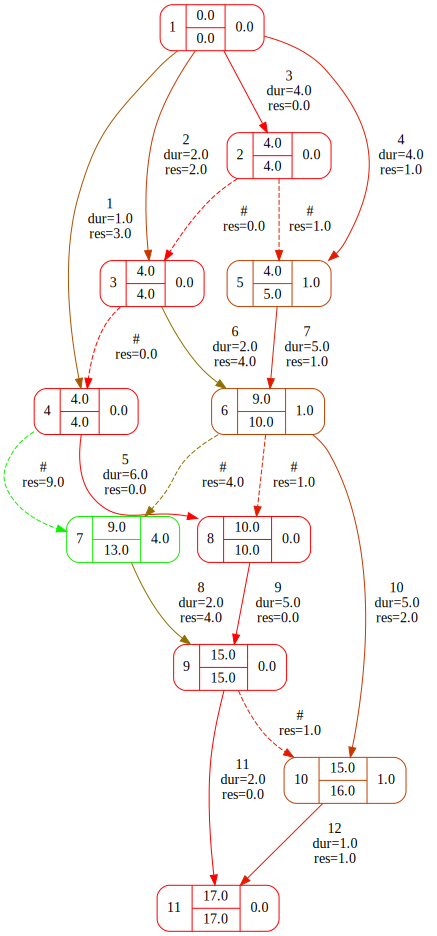

In [16]:
dot = nm.generate_viz()
dot

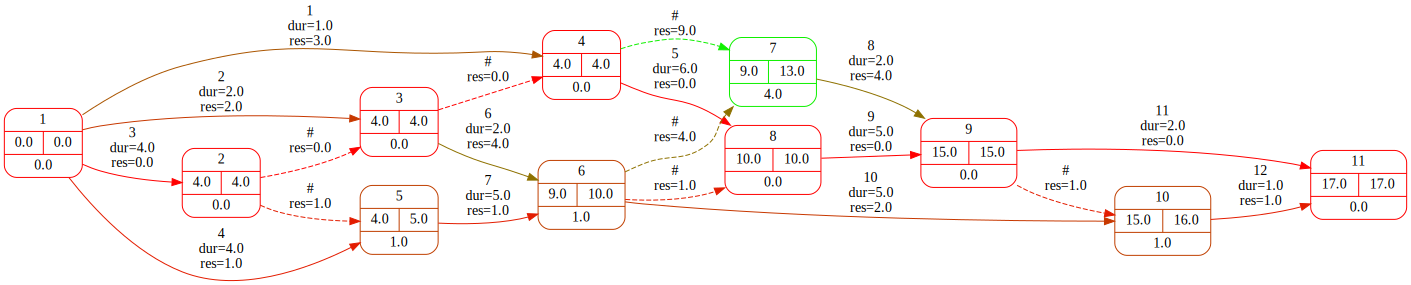

In [17]:
dot.graph_attr['rankdir'] = 'LR'
dot

In [18]:
nm2 = session.query(NetworkModel).get(1)

In [19]:
for a in nm2.activities:
    print(a)

for e in nm2.events:
    print(e)

Activity(model_id=1 id=1, src_id=1, dst_id=4, duration=1.0, reserve=3.0, wbs.path='1', wbs.name='Heating and frames study')
Activity(model_id=1 id=2, src_id=1, dst_id=3, duration=2.0, reserve=2.0, wbs.path='2', wbs.name='Scouring and installation of building site establishment')
Activity(model_id=1 id=3, src_id=1, dst_id=2, duration=4.0, reserve=0.0, wbs.path='3', wbs.name='Earthwork and concrete well')
Activity(model_id=1 id=4, src_id=1, dst_id=5, duration=4.0, reserve=1.0, wbs.path='4', wbs.name='Earthwork and concrete longitudinal beams')
Activity(model_id=1 id=5, src_id=4, dst_id=8, duration=6.0, reserve=0.0, wbs.path='5', wbs.name='Frame construction')
Activity(model_id=1 id=6, src_id=3, dst_id=6, duration=2.0, reserve=4.0, wbs.path='6', wbs.name='Frame transport')
Activity(model_id=1 id=7, src_id=5, dst_id=6, duration=5.0, reserve=1.0, wbs.path='7', wbs.name='Assemblage')
Activity(model_id=1 id=8, src_id=7, dst_id=9, duration=2.0, reserve=4.0, wbs.path='8', wbs.name='Earthwork an

In [20]:
"""
nm3 = nm2.copy()

for a in nm3.activities:
    print(a)

for e in nm3.events:
    print(e)
"""

'\nnm3 = nm2.copy()\n\nfor a in nm3.activities:\n    print(a)\n\nfor e in nm3.events:\n    print(e)\n'

In [21]:
session.commit()

In [22]:
for l in session.query(Link).all():
    print(l)

Link(model_id=1 src_id=1, dst_id=5)
Link(model_id=1 src_id=2, dst_id=5)
Link(model_id=1 src_id=3, dst_id=5)
Link(model_id=1 src_id=2, dst_id=6)
Link(model_id=1 src_id=3, dst_id=6)
Link(model_id=1 src_id=3, dst_id=7)
Link(model_id=1 src_id=4, dst_id=7)
Link(model_id=1 src_id=1, dst_id=8)
Link(model_id=1 src_id=6, dst_id=8)
Link(model_id=1 src_id=7, dst_id=8)
Link(model_id=1 src_id=5, dst_id=9)
Link(model_id=1 src_id=6, dst_id=9)
Link(model_id=1 src_id=7, dst_id=9)
Link(model_id=1 src_id=3, dst_id=10)
Link(model_id=1 src_id=6, dst_id=10)
Link(model_id=1 src_id=7, dst_id=10)
Link(model_id=1 src_id=6, dst_id=11)
Link(model_id=1 src_id=8, dst_id=11)
Link(model_id=1 src_id=9, dst_id=11)
Link(model_id=1 src_id=7, dst_id=12)
Link(model_id=1 src_id=8, dst_id=12)
Link(model_id=1 src_id=9, dst_id=12)
Link(model_id=1 src_id=10, dst_id=12)


In [23]:
for l in session.query(Activity).all():
    print(l)

Activity(model_id=1 id=1, src_id=1, dst_id=4, duration=1.0, reserve=3.0, wbs.path='1', wbs.name='Heating and frames study')
Activity(model_id=1 id=2, src_id=1, dst_id=3, duration=2.0, reserve=2.0, wbs.path='2', wbs.name='Scouring and installation of building site establishment')
Activity(model_id=1 id=3, src_id=1, dst_id=2, duration=4.0, reserve=0.0, wbs.path='3', wbs.name='Earthwork and concrete well')
Activity(model_id=1 id=4, src_id=1, dst_id=5, duration=4.0, reserve=1.0, wbs.path='4', wbs.name='Earthwork and concrete longitudinal beams')
Activity(model_id=1 id=5, src_id=4, dst_id=8, duration=6.0, reserve=0.0, wbs.path='5', wbs.name='Frame construction')
Activity(model_id=1 id=6, src_id=3, dst_id=6, duration=2.0, reserve=4.0, wbs.path='6', wbs.name='Frame transport')
Activity(model_id=1 id=7, src_id=5, dst_id=6, duration=5.0, reserve=1.0, wbs.path='7', wbs.name='Assemblage')
Activity(model_id=1 id=8, src_id=7, dst_id=9, duration=2.0, reserve=4.0, wbs.path='8', wbs.name='Earthwork an

In [24]:
for l in session.query(Event).all():
    print(l)

Event(model_id=1 id=1 early=0.0 late=0.0 reserve=0.0 layer=0)
Event(model_id=1 id=2 early=4.0 late=4.0 reserve=0.0 layer=0)
Event(model_id=1 id=3 early=4.0 late=4.0 reserve=0.0 layer=0)
Event(model_id=1 id=4 early=4.0 late=4.0 reserve=0.0 layer=0)
Event(model_id=1 id=5 early=4.0 late=5.0 reserve=1.0 layer=0)
Event(model_id=1 id=6 early=9.0 late=10.0 reserve=1.0 layer=0)
Event(model_id=1 id=7 early=9.0 late=13.0 reserve=4.0 layer=0)
Event(model_id=1 id=8 early=10.0 late=10.0 reserve=0.0 layer=0)
Event(model_id=1 id=9 early=15.0 late=15.0 reserve=0.0 layer=0)
Event(model_id=1 id=10 early=15.0 late=16.0 reserve=1.0 layer=0)
Event(model_id=1 id=11 early=17.0 late=17.0 reserve=0.0 layer=0)


In [25]:
for l in session.query(WBSRecord).all():
    print(l)

WBSRecord(model_id=1 id=1, path='1', name='Heating and frames study')
WBSRecord(model_id=1 id=2, path='2', name='Scouring and installation of building site establishment')
WBSRecord(model_id=1 id=3, path='3', name='Earthwork and concrete well')
WBSRecord(model_id=1 id=4, path='4', name='Earthwork and concrete longitudinal beams')
WBSRecord(model_id=1 id=5, path='5', name='Frame construction')
WBSRecord(model_id=1 id=6, path='6', name='Frame transport')
WBSRecord(model_id=1 id=7, path='7', name='Assemblage')
WBSRecord(model_id=1 id=8, path='8', name='Earthwork and pose drains')
WBSRecord(model_id=1 id=9, path='9', name='Heating provisioning and assembly')
WBSRecord(model_id=1 id=10, path='10', name='Electric installation')
WBSRecord(model_id=1 id=11, path='11', name='Painting')
WBSRecord(model_id=1 id=12, path='12', name='Pavement')


In [26]:
for l in session.query(NetworkModel).all():
    print(l)